In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('classic')

# PLFS Workload
Clients write to different offsets of a single PLFS file. PLFS is backed by CephFS.

First, we show the namespace structure by plotting the number of files and directories.

,clients,ts,latency,files,dirs,dir_latency
0,1,13:20:56,0:00:00.123444,5,3,0:00:00.089532
1,2,13:25:50,0:00:00.124947,8,3,0:00:00.096625
2,3,13:30:56,0:00:00.110029,11,5,0:00:00.087638
3,4,13:36:01,0:00:00.105487,11,6,0:00:00.087999
4,5,13:41:16,0:00:00.113817,17,6,0:00:00.107801
5,6,13:46:38,0:00:00.115509,20,7,0:00:00.088598


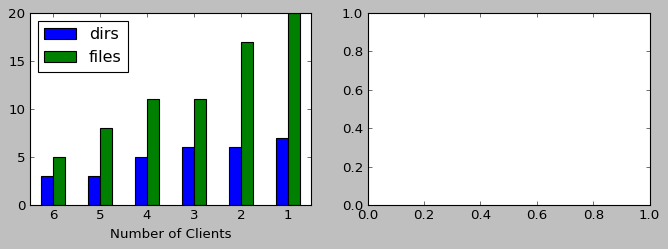

In [3]:
# for this workload, we tested clients all=5, half=3, one=1
clients = [1, 2, 3, 4, 5, 6]

# get and clean the data
df = pd.read_csv("results/files.txt", names=['clients', 'ts', 'latency', 'files'])
df0 = pd.read_csv("results/dirs.txt", names=['clients', 'ts', 'latency', 'dirs'])
df['dirs'] = df0['dirs']
df['dir_latency'] = df0['latency']

# graph namespace
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df[['dirs', 'files']].plot.bar(ax=ax[0])
ax[0].set_xticklabels(clients[::-1], rotation=0)
ax[0].set_xlabel("Number of Clients")

# graph latencies
#df[['dir_latency', 'latency']].plot.bar(ax=ax[1])
#ax[1].set_xticklabels(clients, rotation=0)
#ax[1].set_xlabel("Number of Clients")

fig.savefig('results/namespace.png', dpi=400)
df

,handle_client_request,req_create,req_getattr,req_lookup,req_lookupname,req_mkdir,req_open,req_readdir,req_rename,req_rmdir,req_unlink
0,66.0,6.0,3.0,26.0,0.0,3.0,12.0,4.0,1.0,5.0,12.0
0,229.0,15.0,12.0,124.0,0.0,6.0,33.0,16.0,2.0,13.0,23.0
0,272.0,24.0,44.0,119.0,1.0,9.0,65.0,22.0,3.0,2.0,7.0


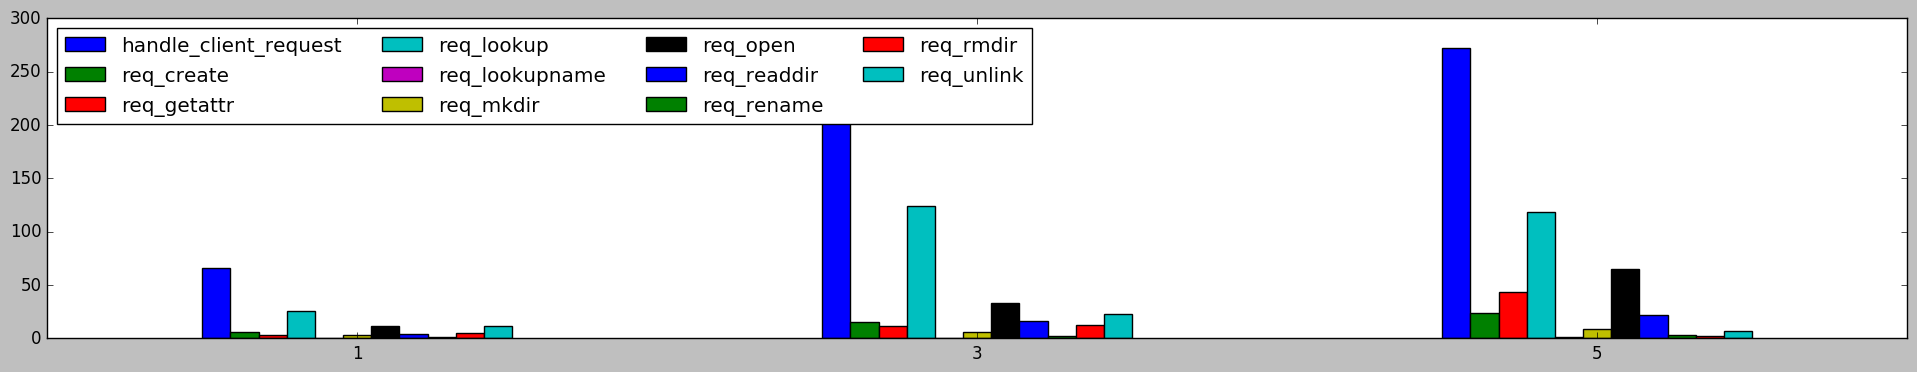

In [41]:
# get column headers
val = pd.DataFrame()
with open ("results/perfdump_all_after") as f:
    data = json.load(f)
    val = json_normalize(data['mds_server'])
df = pd.DataFrame(columns=list(val))

# read in the data
for i in ["one", "half", "all"]:
    with open ("results/perfdump_" + str(i) + "_after") as f:
        data = json.load(f)
        val = json_normalize(data['mds_server'])
    with open ("results/perfdump_" + str(i) + "_before") as f:
        data = json.load(f)
        val = val - json_normalize(data['mds_server'])
    df = df.append(val)
#df = df.set_index([[0, 1, 2, 3, 4, 5]])

# delete things that aren't requests
del df['dispatch_client_request']
del df['dispatch_server_request']
del df['handle_client_session']
del df['handle_slave_request']
for col in list(df):
    if df[col].sum() == 0:
        del df[col]

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, figsize=(24, 4))
ax.set_xticklabels(clients, rotation=0)
ax.legend(ncol=4, loc='upper left')
fig.savefig('results/namespace-requests.png', dpi=400)
df

# RPC Amplication

0    4.333333
0    8.266667
0    4.958333
dtype: float64
0    2.000000
0    2.200000
0    2.708333
dtype: float64
0    6.0
0    5.0
0    4.8
Name: req_create, dtype: float64


,handle_client_request,req_create,req_getattr,req_lookup,req_lookupname,req_mkdir,req_open,req_readdir,req_rename,req_rmdir,req_unlink
0,66.0,6.0,3.0,26.0,0.0,3.0,12.0,4.0,1.0,5.0,12.0
0,229.0,15.0,12.0,124.0,0.0,6.0,33.0,16.0,2.0,13.0,23.0
0,272.0,24.0,44.0,119.0,1.0,9.0,65.0,22.0,3.0,2.0,7.0


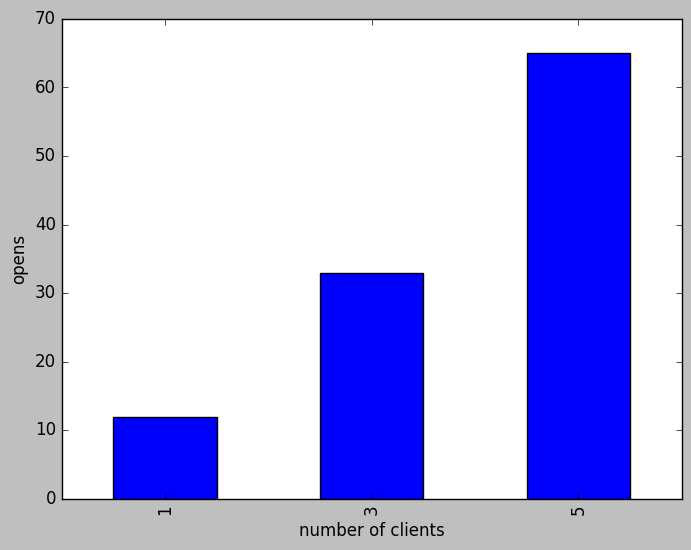

In [42]:
print df['req_lookup']/df['req_create']
print df['req_open']/df['req_create']
x = df['req_open']#/[1, 2, 3, 4, 5, 6]
print df['req_create']/clients
fig, ax = plt.subplots(1, 1)
x.plot.bar(ax=ax)
ax.set_ylabel("opens")
ax.set_xticklabels(clients)
ax.set_xlabel("number of clients")
fig.savefig('results/namespace-opens-per-create.png', dpi=400)
df

# Normalized to Number of Requests

,handle_client_request,req_create,req_getattr,req_lookup,req_lookupname,req_mkdir,req_open,req_readdir,req_rename,req_rmdir,req_unlink
0,66.0,0.090909,0.045455,0.393939,0.000000,0.045455,0.181818,0.060606,0.015152,0.075758,0.181818
0,229.0,0.065502,0.052402,0.541485,0.000000,0.026201,0.144105,0.069869,0.008734,0.056769,0.100437
0,272.0,0.088235,0.161765,0.437500,0.003676,0.033088,0.238971,0.080882,0.011029,0.007353,0.025735


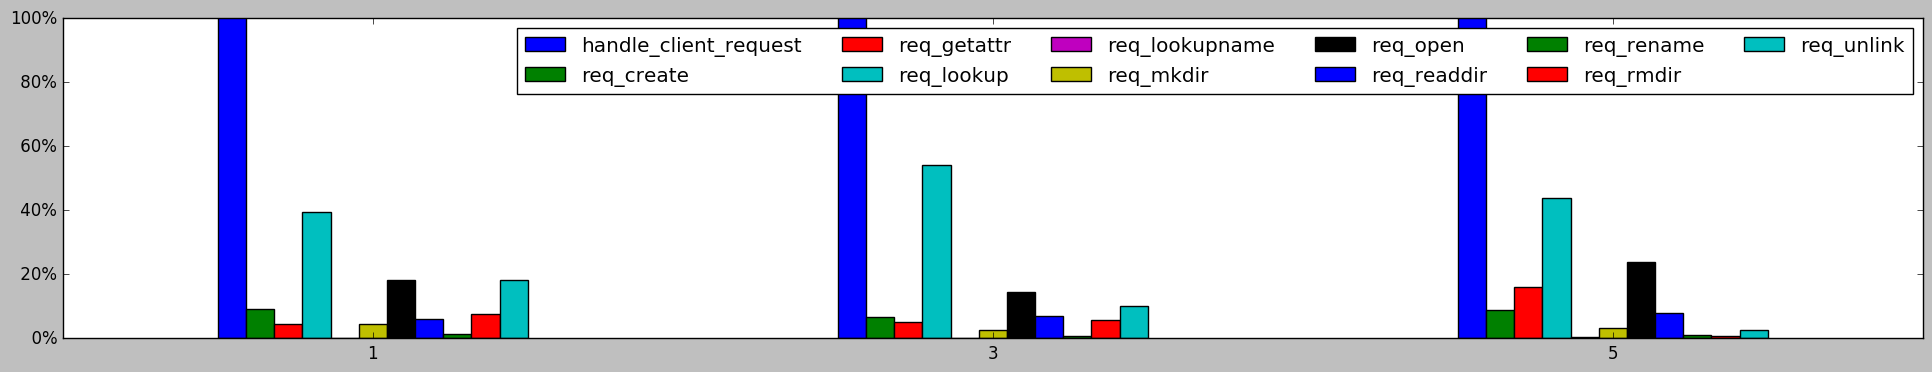

In [43]:
# normalize
for metric in list(df):
    if metric != 'handle_client_request':
        df[metric] = df[metric]/df['handle_client_request']

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, figsize=(24, 4))
ax.set_xticklabels(clients, rotation=0)
ax.legend(ncol=6, loc='upper right')
ax.set_ylim(0, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
fig.savefig('results/namespace-requests-percent.png', dpi=400)
df